# XGBoost Hyperparameter Tuning 

Hyperparameter tuning on our selected model, XGBoost using out chosen feature subset. 

Chosen features derived from RFE are: 
['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b9', 'cut_Ideal', 'color_G', 'color_H']


In [34]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor 

In [3]:
ds = pd.read_csv('./CW1_train.csv')
# Identify categorical columns
categorical_cols = ['cut', 'color', 'clarity']  # Replace with actual categorical column names

# One-hot encode categorical variables
ds = pd.get_dummies(ds, columns=categorical_cols, drop_first=True)

X, y = ds.drop(columns='outcome'), ds['outcome']

# Tuning Single XGBoost Model

### Tuning Tree-specific Parameters

In [ ]:
# Chosen feature subset  
X = X[['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b9', 'cut_Ideal', 'color_G', 'color_H']]

# Parameters we want to experiment with 
params = {
    'max_depth' : [2, 4, 6, 8],
    'min_child_weight' : [1,2,3,4,5],
    'n_estimators' : [100, 500, 1000, 1500],
}

# Runs iterations of XGB model on every combination of n parameters 
gsearch = GridSearchCV(estimator = XGBRegressor(random_state=42), 
param_grid = params, scoring='r2',n_jobs=4, cv=10, return_train_score=True)
gsearch.fit(X, y)

# Log gridsearch information and results 
print(gsearch.best_params_, gsearch.best_score_, gsearch.scorer_)
print(f"mean test score {(gsearch.cv_results_['mean_test_score'])}")
print(f"mean train score {(gsearch.cv_results_['mean_train_score'])}")
print('\n')
print(gsearch.cv_results_)
print('\n')


{'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100} 0.4737843451392451 make_scorer(r2_score, response_method='predict')
mean test score [0.47378435 0.45721165 0.43854093 0.42309252 0.47360354 0.45574854
 0.43699899 0.42336184 0.47352325 0.4570461  0.43790088 0.42268417
 0.47365588 0.45666796 0.43862809 0.42271101 0.47335665 0.45528773
 0.4382441  0.42272373 0.44959856 0.37777333 0.33079642 0.31089152
 0.44868211 0.3739196  0.33174436 0.31005785 0.44875981 0.38046479
 0.34065679 0.31847953 0.45114123 0.37853718 0.33374498 0.31208074
 0.44912611 0.37737169 0.33422645 0.31202853 0.41560973 0.35858258
 0.35293144 0.35231824 0.40714121 0.34908536 0.3420861  0.34154048
 0.41250201 0.35176623 0.3459511  0.34528287 0.4086546  0.3469762
 0.33989351 0.33919998 0.40985657 0.35018088 0.34004483 0.33884414
 0.37945693 0.36345244 0.363408   0.363408   0.37418911 0.35606772
 0.35601224 0.35601224 0.37665307 0.35698491 0.35688241 0.35688241
 0.37051808 0.34816124 0.34802138 0.34802138 0.37068

### Plotting GridSearch Results

Grid search allows me to experiment with every combination of given parameters. `GridSearchCV` was chosen over other K-fold cross validations as not only does Grid search allow ease of parameter tuning, but also provides information and metrics on test/train split data performance. 

But I want to visualise each parameter as independant variables to understand how the model is adjusting and learning based on validation and training curves. To aid in this, this Stack Overflow [forum solution](https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv) presented a very good plot that will be adapted into a function for this notebook. Stack Overflow's [TOS](https://fossid.com/articles/open-source-software-license-risks-copying-code-stack-overflow/#:~:text=Stack%20Overflow%20is%20a%20community,terms%20can%20lead%20to%20problems.) indicates that code can be copied for personal, non-commerical use and is under a Creative Commons license. 

In [29]:
# Credit: https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv 
# Plot by Venkatachalam Natchiappan

# Calculation for standard deviations for test score and train score on each param 
# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 10 # number of splits 
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

def plot_param_val_train(cv_results_df, params):
    # Statistics to display 
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

    # Define subplots 
    fig, axes = plt.subplots(1, len(params), 
                            figsize = (5*len(params), 7),
                            sharey='row')

    axes[0].set_ylabel("Score", fontsize=25)

    lw = 2 # lineweight 

    for idx, (param_name, param_range) in enumerate(params.items()):
        grouped_df = cv_results_df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

        previous_group = cv_results_df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, 
                    grouped_df['mean_train_score'],
                    label="Training score",
                    color="darkorange",
                    lw=lw)
        axes[idx].fill_between(param_range,
                    grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'],
                    alpha=0.2,
                    color="darkorange",
                    lw=lw)
        axes[idx].plot(param_range,
                    grouped_df['mean_test_score'],
                    label="Cross-validation score",
                    color="navy",
                    lw=lw)
        axes[idx].fill_between(param_range,
                        grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'],
                        alpha=0.2,
                        color="navy",
                        lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Train Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

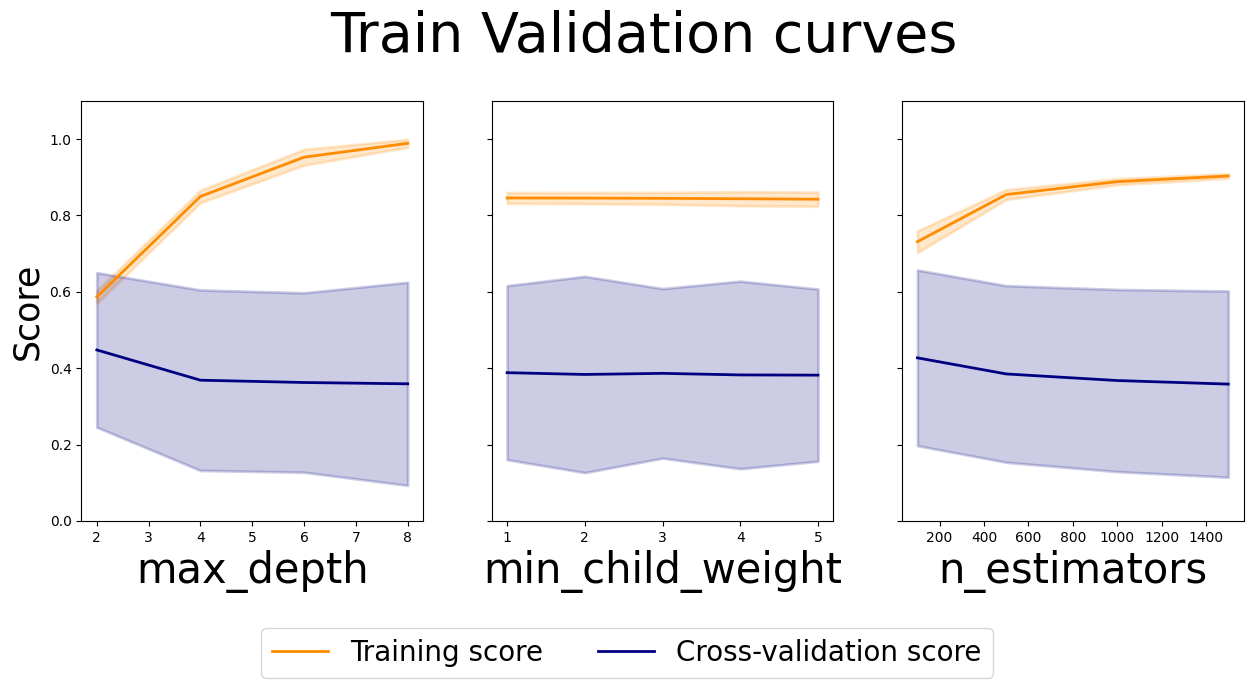

In [30]:
plot_param_val_train( pd.DataFrame(gsearch.cv_results_), params)


From this plot and the grid search optimum parameters, we know the optimum parameters as of currently are: 
- max_depth = 2 
- min_child_weight =  1 
- n_estimators = 100

Where the R2 score is 0.4737843451392451. 

This informative plot also informs us that the model is grossly underfitting, as both curves do not show a strong trend in loss reduction. This also potentially hints at the model not being able to learn enough from the limited data given. All Cross-validation scores also have high variance. 

### Tuning regularisation parameters 

In [ ]:
# Parameters to experiment with
params = {
    'gamma' : [10, 50, 100, 1000],
    'reg_lambda': [100, 200, 300, 400],
    'reg_alpha': [100, 200, 300, 400],
}

# Runs iterations of XGB on every combination of n parameters 
gsearch = GridSearchCV(estimator = XGBRegressor(max_depth = 2, min_child_weight = 1, n_estimators = 100, random_state=42), 
param_grid = params, scoring='r2',n_jobs=4, cv=10, return_train_score=True)
gsearch.fit(X, y)

# Log gridsearch information and results 
print(gsearch.best_params_, gsearch.best_score_, gsearch.scorer_)
print(f"mean test score {(gsearch.cv_results_['mean_test_score'])}")
print(f"mean train score {(gsearch.cv_results_['mean_train_score'])}")
print('\n')
print(gsearch.cv_results_)
print('\n')


{'gamma': 10, 'reg_alpha': 100, 'reg_lambda': 200} 0.47799873852993713 make_scorer(r2_score, response_method='predict')
mean test score [0.47648864 0.47799874 0.47644511 0.47557844 0.47588339 0.47749927
 0.47546843 0.47510272 0.47358659 0.47486754 0.47356271 0.47447165
 0.47410113 0.47367649 0.47306145 0.47274189 0.47504593 0.47660247
 0.474837   0.47416993 0.47382559 0.47476599 0.47352985 0.47284514
 0.47249736 0.47383021 0.47251196 0.47305983 0.47303575 0.47247727
 0.47197571 0.4717694  0.47364481 0.47524574 0.47333267 0.47295807
 0.47311106 0.47403144 0.47274378 0.47199198 0.47179299 0.47289569
 0.4721     0.47251705 0.47233879 0.47149934 0.47108092 0.4706882
 0.46538621 0.46750158 0.46483093 0.46366148 0.46504633 0.46468267
 0.46343921 0.46241867 0.46252294 0.46322366 0.46122522 0.46159287
 0.46236246 0.46154333 0.45992386 0.46038785]
mean train score [0.50792185 0.50559407 0.50392085 0.5028609  0.50179957 0.50120104
 0.49999938 0.50032922 0.49704348 0.49687916 0.49645524 0.4959716

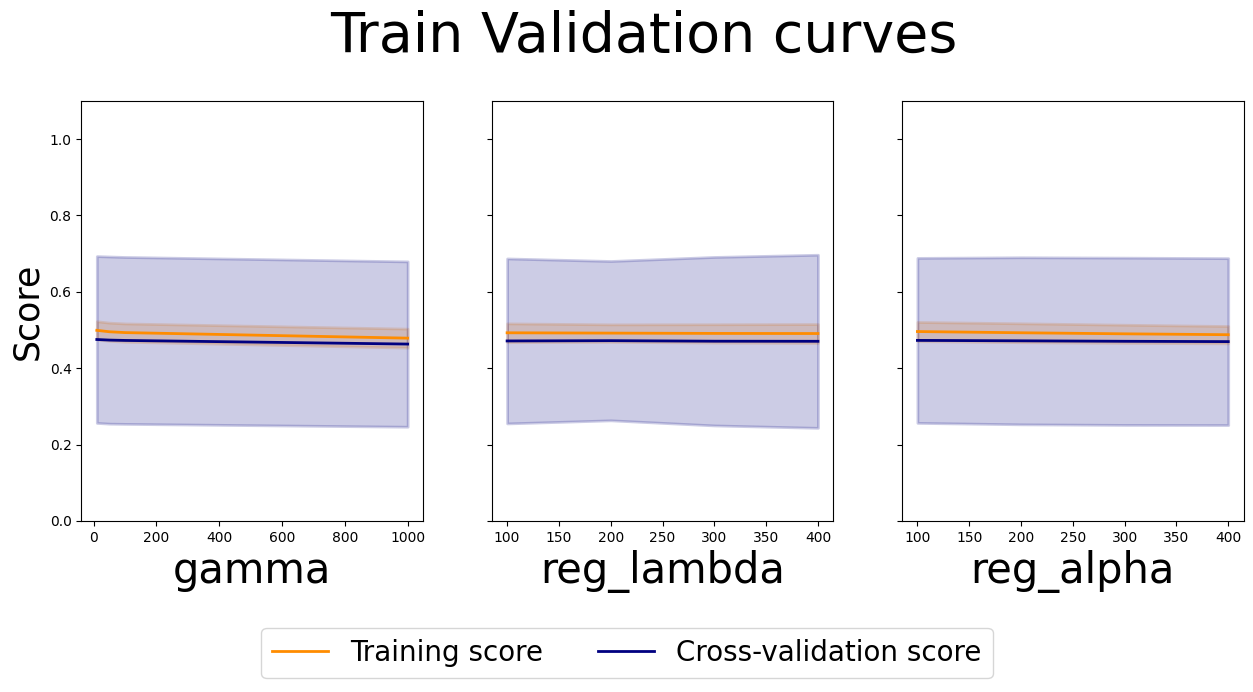

In [33]:
plot_param_val_train( pd.DataFrame(gsearch.cv_results_), params)

As you can see from the graph, tweaking these regularisation parameters only helps with minute improvements. Our optimum parameters are: 'gamma': 10, 'reg_alpha': 100, 'reg_lambda': 200. Whic hallows us to achieve an R2 of 0.47799873852993713. 

## Bagging ensemble with XGBoost 

Inspired by this [conceptual example](https://xgboosting.com/bagging-ensemble-with-xgboost-models/) of utilising XGBoost regressor as an base estimator model Bagging regressor. This ensemble could potentially improve the model's generatlisation performance on validation data. It can also help reduce the variance. After some hyperparameter tuning, I managed to achieve an R2 score of 0.47902. 

In [ ]:
# Final hyper-tuned parameters 
XGB_params = {'scale_pos_weight': 1, 
              'eta': 0.31,
              'gamma': 40.006000, 
              'max_depth': 2, 
              'n_estimators': 1000, 
              'reg_lambda': 100, 
              'reg_alpha': 637, 
              'subsample':0.8, 
              'colsample_bynode':0.8, 
              'colsample_bylevel': 0.9, 
              'colsample_bytree' : 0.9, 
              'random_state':42}

# Initialise Models 
model = XGBRegressor(**XGB_params)
xgb_bagging = BaggingRegressor(estimator=model, random_state=42)

bagging_param = {'n_estimators': [16]}

# Train model 
bagging_gsearch = GridSearchCV(estimator = xgb_bagging, 
param_grid = bagging_param, scoring='r2',n_jobs=4, cv=10, return_train_score=True)
bagging_gsearch.fit(X, y)

# Log information and results 
print(bagging_gsearch.best_params_, bagging_gsearch.best_score_, bagging_gsearch.scorer_)
print(f"mean test score {(bagging_gsearch.cv_results_['mean_test_score'])}")
print(f"mean train score {(bagging_gsearch.cv_results_['mean_train_score'])}")
print('\n')
print(bagging_gsearch.cv_results_)
print('\n')

{'n_estimators': 16} 0.47902414396696463 make_scorer(r2_score, response_method='predict')
mean test score [0.47902414]
mean train score [0.50486496]


{'mean_fit_time': array([15.07337608]), 'std_fit_time': array([3.17304363]), 'mean_score_time': array([0.10179319]), 'std_score_time': array([0.03747614]), 'param_n_estimators': masked_array(data=[16],
             mask=[False],
       fill_value=999999), 'params': [{'n_estimators': 16}], 'split0_test_score': array([0.47037841]), 'split1_test_score': array([0.48907011]), 'split2_test_score': array([0.49180002]), 'split3_test_score': array([0.47163371]), 'split4_test_score': array([0.48685128]), 'split5_test_score': array([0.49472414]), 'split6_test_score': array([0.46188093]), 'split7_test_score': array([0.50269417]), 'split8_test_score': array([0.42233449]), 'split9_test_score': array([0.49887417]), 'mean_test_score': array([0.47902414]), 'std_test_score': array([0.0227226]), 'rank_test_score': array([1], dtype=int32), 'split0_train_sco

### Visualise performance comparison between single and bagged XGBoost

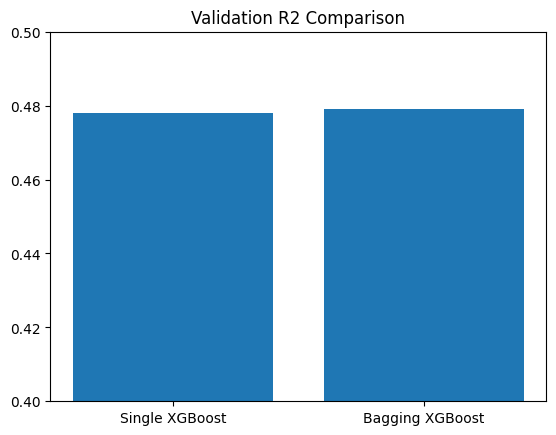

In [ ]:
# Visualise the performance comparison between singular XGBoost and XGBoost bagging 

val_R2_score = [gsearch.best_score_, (bagging_gsearch.cv_results_['mean_test_score'][0])]

models = ['Single XGBoost', 'Bagging XGBoost']

# Plot bar chart of validation R2 Scores 
plt.bar(models, val_R2_score)
plt.title('Validation R2 Comparison')
plt.ylim(0.4, 0.5)
plt.show()

Bagging-XGBoost allowed validation R2 to in-
crease from 0.4737843 to 0.47902414.